## Prévision de la consomation d'un mois 

In [3]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 4)
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
import seaborn as sns
color_pal = sns.color_palette("husl", 9)
sns.set(style="whitegrid")
import matplotlib.dates as mdates
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from colorama import Fore


from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


from datetime import datetime, date
import math
import os
import re
import missingno as msno
from tqdm import tqdm

In [4]:
weather_and_consumption_df = pd.read_csv("../data/02_processed/processed_weather_and_consumption_data.csv", index_col=0, parse_dates=True,)


In [5]:
df = weather_and_consumption_df.copy()

## Features

In [6]:
def create_features(df, column_names, lags, window_sizes):
    """
    Create time series features based on time series index and add lag and rolling features for specified columns.
    """
    created_features = []

    basic_features = ["dayofweek", "quarter", "month", "year", "dayofyear"]
    for feature in basic_features:
        df[feature] = getattr(df.index, feature)
        created_features.append(feature)

    for column_name in column_names:
        for lag in lags:
            lag_feature_name = f"{column_name}_lag_{lag}"
            df[lag_feature_name] = df[column_name].shift(lag)
            created_features.append(lag_feature_name)

        for window in window_sizes:
            rolling_mean_name = f"{column_name}_rolling_mean_{window}"
            df[rolling_mean_name] = (
                df[column_name].shift(1).rolling(window=window).mean()
            )
            created_features.append(rolling_mean_name)

    return df, created_features

In [7]:
df, created_features = create_features(
    df,
    column_names=[
        "total_consumption",
        "Global_intensity",
        "Sub_metering_3",
        "Sub_metering_1",
        "temp",
        "day_length",
        "tempmax",
        "feelslike",
        "feelslikemax",
        "feelslikemin",
        "tempmin",
    ],
    lags=[1, 2, 3, 4, 5, 6, 7, 30, 90, 365],
    window_sizes=[2, 3, 4, 5, 6, 7, 30, 90, 365],
)

In [8]:
EXTERNAL_FEATURES = [
    "tempmax",
    "tempmin",
    "temp",
    "feelslikemax",
    "feelslikemin",
    "feelslike",
    "dew",
    "humidity",
    "precip",
    "precipprob",
    "precipcover",
    "snow",
    "snowdepth",
    "windgust",
    "windspeed",
    "winddir",
    "sealevelpressure",
    "cloudcover",
    "visibility",
    "moonphase",
    "conditions_clear",
    "conditions_overcast",
    "conditions_partiallycloudy",
    "conditions_rain",
    "conditions_rainovercast",
    "conditions_rainpartiallycloudy",
    "conditions_snowovercast",
    "conditions_snowpartiallycloudy",
    "conditions_snowrain",
    "conditions_snowrainovercast",
    "conditions_snowrainpartiallycloudy",
    "day_length",
    "is_holiday",
]
FEATURES = created_features
df["target_30d"] = df["total_consumption"].shift(-30)
df = df.dropna(subset=["target_30d"])
TARGET = "target_30d"


In [9]:
df.head(1)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length,is_holiday,dayofweek,quarter,month,year,dayofyear,total_consumption_lag_1,total_consumption_lag_2,total_consumption_lag_3,total_consumption_lag_4,total_consumption_lag_5,total_consumption_lag_6,total_consumption_lag_7,total_consumption_lag_30,total_consumption_lag_90,total_consumption_lag_365,total_consumption_rolling_mean_2,total_consumption_rolling_mean_3,total_consumption_rolling_mean_4,total_consumption_rolling_mean_5,total_consumption_rolling_mean_6,total_consumption_rolling_mean_7,total_consumption_rolling_mean_30,total_consumption_rolling_mean_90,total_consumption_rolling_mean_365,Global_intensity_lag_1,Global_intensity_lag_2,Global_intensity_lag_3,Global_intensity_lag_4,Global_intensity_lag_5,Global_intensity_lag_6,Global_intensity_lag_7,Global_intensity_lag_30,Global_intensity_lag_90,Global_intensity_lag_365,Global_intensity_rolling_mean_2,Global_intensity_rolling_mean_3,Global_intensity_rolling_mean_4,Global_intensity_rolling_mean_5,Global_intensity_rolling_mean_6,Global_intensity_rolling_mean_7,Global_intensity_rolling_mean_30,Global_intensity_rolling_mean_90,Global_intensity_rolling_mean_365,Sub_metering_3_lag_1,Sub_metering_3_lag_2,Sub_metering_3_lag_3,Sub_metering_3_lag_4,Sub_metering_3_lag_5,Sub_metering_3_lag_6,Sub_metering_3_lag_7,Sub_metering_3_lag_30,Sub_metering_3_lag_90,Sub_metering_3_lag_365,Sub_metering_3_rolling_mean_2,Sub_metering_3_rolling_mean_3,Sub_metering_3_rolling_mean_4,Sub_metering_3_rolling_mean_5,Sub_metering_3_rolling_mean_6,Sub_metering_3_rolling_mean_7,Sub_metering_3_rolling_mean_30,Sub_metering_3_rolling_mean_90,Sub_metering_3_rolling_mean_365,Sub_metering_1_lag_1,Sub_metering_1_lag_2,Sub_metering_1_lag_3,Sub_metering_1_lag_4,Sub_metering_1_lag_5,Sub_metering_1_lag_6,Sub_metering_1_lag_7,Sub_metering_1_lag_30,Sub_metering_1_lag_90,Sub_metering_1_lag_365,Sub_metering_1_rolling_mean_2,Sub_metering_1_rolling_mean_3,Sub_metering_1_rolling_mean_4,Sub_metering_1_rolling_mean_5,Sub_metering_1_rolling_mean_6,Sub_metering_1_rolling_mean_7,Sub_metering_1_rolling_mean_30,Sub_metering_1_rolling_mean_90,Sub_metering_1_rolling_mean_365,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_4,temp_lag_5,temp_lag_6,temp_lag_7,temp_lag_30,temp_lag_90,temp_lag_365,temp_rolling_mean_2,temp_rolling_mean_3,temp_rolling_mean_4,temp_rolling_mean_5,temp_rolling_mean_6,temp_rolling_mean_7,temp_rolling_mean_30,temp_rolling_mean_90,temp_rolling_mean_365,day_length_lag_1,day_length_lag_2,day_length_lag_3,day_length_lag_4,day_length_lag_5,day_length_lag_6,day_length_lag_7,day_length_lag_30,day_length_lag_90,day_length_lag_365,day_length_rolling_mean_2,day_length_rolling_mean_3,day_length_rolling_mean_4,day_length_rolling_mean_5,day_length_rolling_mean_6,day_length_rolling_mean_7,day_length_rolling_mean_30,day_length_rolling_mean_90,day_length_rolling_mean_365,tempmax_lag_1,tempmax_lag_2,tempmax_lag_3,tempmax_lag_4,tempmax_lag_5,tempmax_lag_6,tempmax_lag_7,tempmax_lag_30,tempmax_lag_90,tempmax_lag_365,tempmax_rolling_mean_2,tempmax_rolling_mean_3,tempmax_rolling_mean_4,tempmax_rolling_mean_5,tempmax_rolling_mean_6,tempmax_rolling_mean_7,tempmax_rolling_mean_30,tempmax_rolling_mean_90,tempmax_rolling_mean_365,feelslike_lag_1,feelslike_lag_2,feelslike_lag_3,feelslike_lag_4,feelslike_lag_5,feelslike_lag_6,feelslike_lag_7,feelslike_lag_30,feelslike_lag_90,feelslike_lag_365,feelslike_rolling_mean_2,feelslike_rolling_mean_3,feelslike_rolling_mean_4,feelslike_rol

In [10]:
df = df.dropna()


In [11]:
df.head(1)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length,is_holiday,dayofweek,quarter,month,year,dayofyear,total_consumption_lag_1,total_consumption_lag_2,total_consumption_lag_3,total_consumption_lag_4,total_consumption_lag_5,total_consumption_lag_6,total_consumption_lag_7,total_consumption_lag_30,total_consumption_lag_90,total_consumption_lag_365,total_consumption_rolling_mean_2,total_consumption_rolling_mean_3,total_consumption_rolling_mean_4,total_consumption_rolling_mean_5,total_consumption_rolling_mean_6,total_consumption_rolling_mean_7,total_consumption_rolling_mean_30,total_consumption_rolling_mean_90,total_consumption_rolling_mean_365,Global_intensity_lag_1,Global_intensity_lag_2,Global_intensity_lag_3,Global_intensity_lag_4,Global_intensity_lag_5,Global_intensity_lag_6,Global_intensity_lag_7,Global_intensity_lag_30,Global_intensity_lag_90,Global_intensity_lag_365,Global_intensity_rolling_mean_2,Global_intensity_rolling_mean_3,Global_intensity_rolling_mean_4,Global_intensity_rolling_mean_5,Global_intensity_rolling_mean_6,Global_intensity_rolling_mean_7,Global_intensity_rolling_mean_30,Global_intensity_rolling_mean_90,Global_intensity_rolling_mean_365,Sub_metering_3_lag_1,Sub_metering_3_lag_2,Sub_metering_3_lag_3,Sub_metering_3_lag_4,Sub_metering_3_lag_5,Sub_metering_3_lag_6,Sub_metering_3_lag_7,Sub_metering_3_lag_30,Sub_metering_3_lag_90,Sub_metering_3_lag_365,Sub_metering_3_rolling_mean_2,Sub_metering_3_rolling_mean_3,Sub_metering_3_rolling_mean_4,Sub_metering_3_rolling_mean_5,Sub_metering_3_rolling_mean_6,Sub_metering_3_rolling_mean_7,Sub_metering_3_rolling_mean_30,Sub_metering_3_rolling_mean_90,Sub_metering_3_rolling_mean_365,Sub_metering_1_lag_1,Sub_metering_1_lag_2,Sub_metering_1_lag_3,Sub_metering_1_lag_4,Sub_metering_1_lag_5,Sub_metering_1_lag_6,Sub_metering_1_lag_7,Sub_metering_1_lag_30,Sub_metering_1_lag_90,Sub_metering_1_lag_365,Sub_metering_1_rolling_mean_2,Sub_metering_1_rolling_mean_3,Sub_metering_1_rolling_mean_4,Sub_metering_1_rolling_mean_5,Sub_metering_1_rolling_mean_6,Sub_metering_1_rolling_mean_7,Sub_metering_1_rolling_mean_30,Sub_metering_1_rolling_mean_90,Sub_metering_1_rolling_mean_365,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_4,temp_lag_5,temp_lag_6,temp_lag_7,temp_lag_30,temp_lag_90,temp_lag_365,temp_rolling_mean_2,temp_rolling_mean_3,temp_rolling_mean_4,temp_rolling_mean_5,temp_rolling_mean_6,temp_rolling_mean_7,temp_rolling_mean_30,temp_rolling_mean_90,temp_rolling_mean_365,day_length_lag_1,day_length_lag_2,day_length_lag_3,day_length_lag_4,day_length_lag_5,day_length_lag_6,day_length_lag_7,day_length_lag_30,day_length_lag_90,day_length_lag_365,day_length_rolling_mean_2,day_length_rolling_mean_3,day_length_rolling_mean_4,day_length_rolling_mean_5,day_length_rolling_mean_6,day_length_rolling_mean_7,day_length_rolling_mean_30,day_length_rolling_mean_90,day_length_rolling_mean_365,tempmax_lag_1,tempmax_lag_2,tempmax_lag_3,tempmax_lag_4,tempmax_lag_5,tempmax_lag_6,tempmax_lag_7,tempmax_lag_30,tempmax_lag_90,tempmax_lag_365,tempmax_rolling_mean_2,tempmax_rolling_mean_3,tempmax_rolling_mean_4,tempmax_rolling_mean_5,tempmax_rolling_mean_6,tempmax_rolling_mean_7,tempmax_rolling_mean_30,tempmax_rolling_mean_90,tempmax_rolling_mean_365,feelslike_lag_1,feelslike_lag_2,feelslike_lag_3,feelslike_lag_4,feelslike_lag_5,feelslike_lag_6,feelslike_lag_7,feelslike_lag_30,feelslike_lag_90,feelslike_lag_365,feelslike_rolling_mean_2,feelslike_rolling_mean_3,feelslike_rolling_mean_4,feelslike_rol

In [12]:
df.tail(1)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length,is_holiday,dayofweek,quarter,month,year,dayofyear,total_consumption_lag_1,total_consumption_lag_2,total_consumption_lag_3,total_consumption_lag_4,total_consumption_lag_5,total_consumption_lag_6,total_consumption_lag_7,total_consumption_lag_30,total_consumption_lag_90,total_consumption_lag_365,total_consumption_rolling_mean_2,total_consumption_rolling_mean_3,total_consumption_rolling_mean_4,total_consumption_rolling_mean_5,total_consumption_rolling_mean_6,total_consumption_rolling_mean_7,total_consumption_rolling_mean_30,total_consumption_rolling_mean_90,total_consumption_rolling_mean_365,Global_intensity_lag_1,Global_intensity_lag_2,Global_intensity_lag_3,Global_intensity_lag_4,Global_intensity_lag_5,Global_intensity_lag_6,Global_intensity_lag_7,Global_intensity_lag_30,Global_intensity_lag_90,Global_intensity_lag_365,Global_intensity_rolling_mean_2,Global_intensity_rolling_mean_3,Global_intensity_rolling_mean_4,Global_intensity_rolling_mean_5,Global_intensity_rolling_mean_6,Global_intensity_rolling_mean_7,Global_intensity_rolling_mean_30,Global_intensity_rolling_mean_90,Global_intensity_rolling_mean_365,Sub_metering_3_lag_1,Sub_metering_3_lag_2,Sub_metering_3_lag_3,Sub_metering_3_lag_4,Sub_metering_3_lag_5,Sub_metering_3_lag_6,Sub_metering_3_lag_7,Sub_metering_3_lag_30,Sub_metering_3_lag_90,Sub_metering_3_lag_365,Sub_metering_3_rolling_mean_2,Sub_metering_3_rolling_mean_3,Sub_metering_3_rolling_mean_4,Sub_metering_3_rolling_mean_5,Sub_metering_3_rolling_mean_6,Sub_metering_3_rolling_mean_7,Sub_metering_3_rolling_mean_30,Sub_metering_3_rolling_mean_90,Sub_metering_3_rolling_mean_365,Sub_metering_1_lag_1,Sub_metering_1_lag_2,Sub_metering_1_lag_3,Sub_metering_1_lag_4,Sub_metering_1_lag_5,Sub_metering_1_lag_6,Sub_metering_1_lag_7,Sub_metering_1_lag_30,Sub_metering_1_lag_90,Sub_metering_1_lag_365,Sub_metering_1_rolling_mean_2,Sub_metering_1_rolling_mean_3,Sub_metering_1_rolling_mean_4,Sub_metering_1_rolling_mean_5,Sub_metering_1_rolling_mean_6,Sub_metering_1_rolling_mean_7,Sub_metering_1_rolling_mean_30,Sub_metering_1_rolling_mean_90,Sub_metering_1_rolling_mean_365,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_4,temp_lag_5,temp_lag_6,temp_lag_7,temp_lag_30,temp_lag_90,temp_lag_365,temp_rolling_mean_2,temp_rolling_mean_3,temp_rolling_mean_4,temp_rolling_mean_5,temp_rolling_mean_6,temp_rolling_mean_7,temp_rolling_mean_30,temp_rolling_mean_90,temp_rolling_mean_365,day_length_lag_1,day_length_lag_2,day_length_lag_3,day_length_lag_4,day_length_lag_5,day_length_lag_6,day_length_lag_7,day_length_lag_30,day_length_lag_90,day_length_lag_365,day_length_rolling_mean_2,day_length_rolling_mean_3,day_length_rolling_mean_4,day_length_rolling_mean_5,day_length_rolling_mean_6,day_length_rolling_mean_7,day_length_rolling_mean_30,day_length_rolling_mean_90,day_length_rolling_mean_365,tempmax_lag_1,tempmax_lag_2,tempmax_lag_3,tempmax_lag_4,tempmax_lag_5,tempmax_lag_6,tempmax_lag_7,tempmax_lag_30,tempmax_lag_90,tempmax_lag_365,tempmax_rolling_mean_2,tempmax_rolling_mean_3,tempmax_rolling_mean_4,tempmax_rolling_mean_5,tempmax_rolling_mean_6,tempmax_rolling_mean_7,tempmax_rolling_mean_30,tempmax_rolling_mean_90,tempmax_rolling_mean_365,feelslike_lag_1,feelslike_lag_2,feelslike_lag_3,feelslike_lag_4,feelslike_lag_5,feelslike_lag_6,feelslike_lag_7,feelslike_lag_30,feelslike_lag_90,feelslike_lag_365,feelslike_rolling_mean_2,feelslike_rolling_mean_3,feelslike_rolling_mean_4,feelslike_rol

In [13]:
threshold = "2010-02-04"
train_df = df.loc[df.index < threshold].copy()
test_df = df.loc[df.index >= threshold].copy()
X_train = train_df[FEATURES + EXTERNAL_FEATURES]
y_train = train_df[TARGET]
X_test = test_df[FEATURES + EXTERNAL_FEATURES]
y_test = test_df[TARGET]


In [ ]:
import os
import joblib

#os.makedirs("/data/03_training_data", exist_ok=True)
X_train.to_csv(r"C:\Users\EL mahjoubi\Desktop\Prédiction-Consomation-Energie\data\03_training_data\X_train.csv")
X_test.to_csv(r"C:\Users\EL mahjoubi\Desktop\Prédiction-Consomation-Energie\data\03_training_data\X_test.csv")
y_train.to_frame().to_csv(r"C:\Users\EL mahjoubi\Desktop\Prédiction-Consomation-Energie\data\03_training_data\y_train.csv")
y_test.to_frame().to_csv(r"C:\Users\EL mahjoubi\Desktop\Prédiction-Consomation-Energie\data\03_training_data\y_test.csv")


"../data/02_processed/processed_weather_and_consumption_data.csv


## Training


In [14]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth=3)

In [18]:
import xgboost as xgb

In [19]:
xgb = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=1000,
    early_stopping_rounds=50,
    objective="reg:linear",
    max_depth=3,
    learning_rate=0.01,
)


In [20]:
import lightgbm as lgb

lgb = lgb.LGBMRegressor(
    boosting_type="gbdt",
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.2,
    n_estimators=1000,
    force_col_wise=True,
)

In [15]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=1000)

In [22]:
xgb.fit(
    X_train, y_train, verbose=100, eval_set=[(X_train, y_train), (X_train, y_train)]
)

[0]	validation_0-rmse:1645.24494	validation_1-rmse:1645.24494
[100]	validation_0-rmse:702.82639	validation_1-rmse:702.82639
[200]	validation_0-rmse:414.09114	validation_1-rmse:414.09114
[300]	validation_0-rmse:334.94110	validation_1-rmse:334.94110
[400]	validation_0-rmse:303.19823	validation_1-rmse:303.19823
[500]	validation_0-rmse:284.41758	validation_1-rmse:284.41758
[600]	validation_0-rmse:270.76546	validation_1-rmse:270.76546
[700]	validation_0-rmse:257.81172	validation_1-rmse:257.81172
[800]	validation_0-rmse:246.93206	validation_1-rmse:246.93206
[900]	validation_0-rmse:237.39032	validation_1-rmse:237.39032
[999]	validation_0-rmse:228.39699	validation_1-rmse:228.39699


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [23]:
lgb.fit(X_train, y_train, eval_set=[(X_train, y_train)], eval_metric="l2")

[LightGBM] [Info] Total Bins 53499
[LightGBM] [Info] Number of data points in the train set: 781, number of used features: 239
[LightGBM] [Info] Start training from score 1559.228937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMRegressor(force_col_wise=True, learning_rate=0.2, n_estimators=1000)

In [25]:
joblib.dump(rfr, r"C:\Users\EL mahjoubi\Desktop\Prédiction-Consomation-Energie\data\05_models\random_forest_model.pkl")
joblib.dump(xgb, r"C:\Users\EL mahjoubi\Desktop\Prédiction-Consomation-Energie\data\05_models\xgboost_model.pkl")
joblib.dump(lgb, r"C:\Users\EL mahjoubi\Desktop\Prédiction-Consomation-Energie\data\05_models\lightgbm_model.pkl")


['C:\\Users\\EL mahjoubi\\Desktop\\Prédiction-Consomation-Energie\\data\\05_models\\lightgbm_model.pkl']

#### Analyse des Caractéristiques 

In [62]:
feature_data_rfr = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance": rfr.feature_importances_,
        "Model": "Random Forest",
    }
)

feature_data_xgb = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance": xgb.feature_importances_,
        "Model": "XGBoost",
    }
)

feature_data_lgb = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance": lgb.feature_importances_,
        "Model": "LightGBM",
    }
)

In [63]:
feature_data_combined = pd.concat(
    [feature_data_rfr, feature_data_xgb, feature_data_lgb]
)

In [64]:
top_features_rfr = feature_data_rfr.sort_values(by="Importance", ascending=False).head(
    8
)
top_features_xgb = feature_data_xgb.sort_values(by="Importance", ascending=False).head(
    8
)
top_features_lgb = feature_data_lgb.sort_values(by="Importance", ascending=False).head(
    8
) 



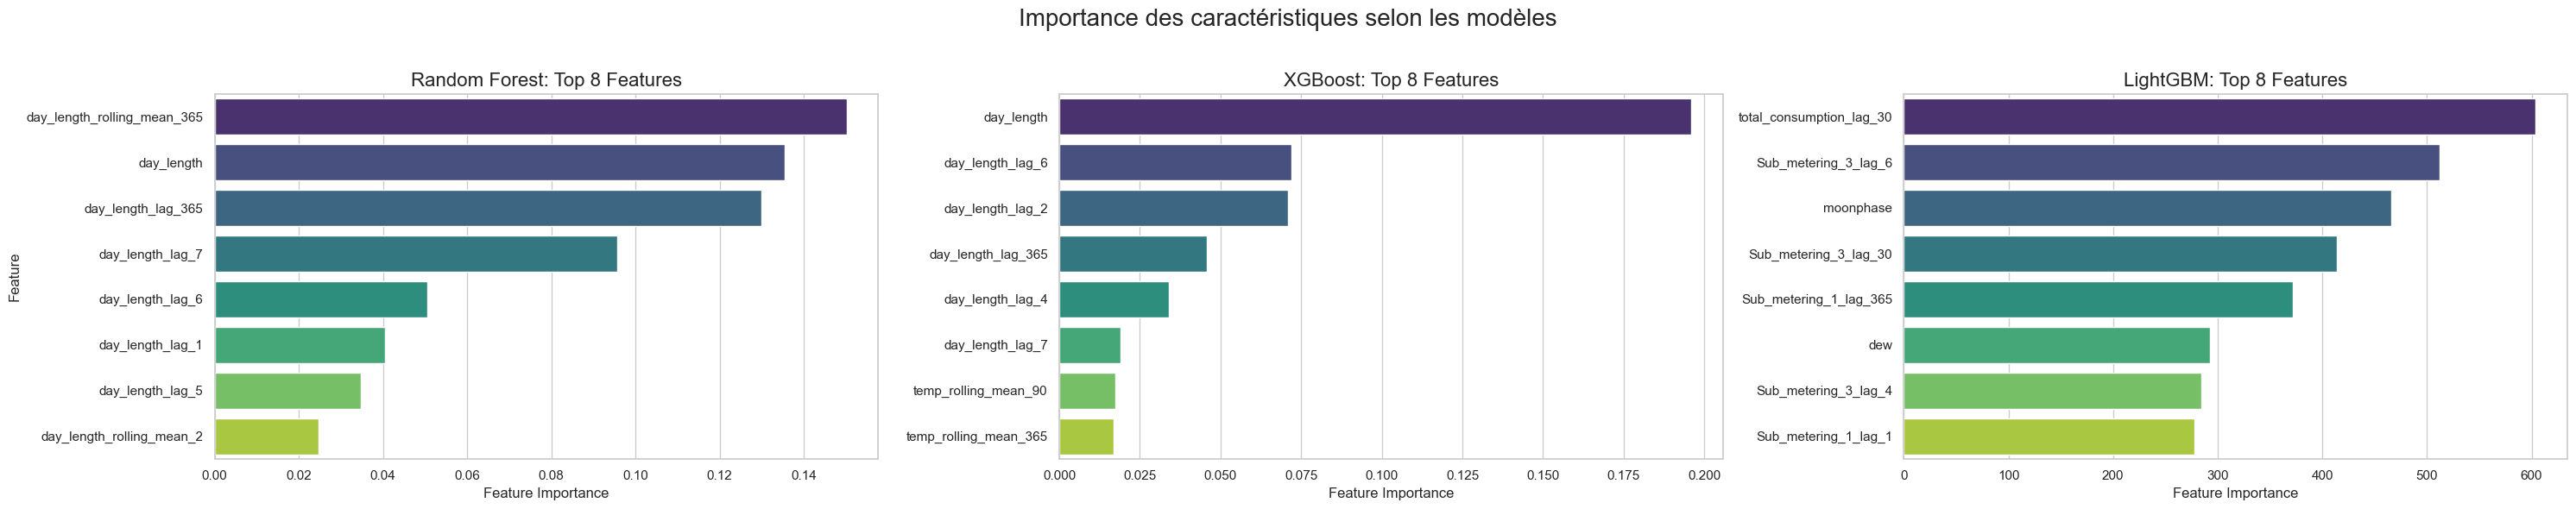

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(30, 6))  

sns.barplot(
    data=top_features_rfr, x="Importance", y="Feature", palette="viridis", ax=axs[0]
)
axs[0].set_title("Random Forest: Top 8 Features", fontsize=16)
axs[0].set_xlabel("Feature Importance", fontsize=12)
axs[0].set_ylabel("Feature", fontsize=12)


sns.barplot(
    data=top_features_xgb, x="Importance", y="Feature", palette="viridis", ax=axs[1]
)
axs[1].set_title("XGBoost: Top 8 Features", fontsize=16)
axs[1].set_xlabel("Feature Importance", fontsize=12)
axs[1].set_ylabel("", fontsize=12)  


sns.barplot(
    data=top_features_lgb, x="Importance", y="Feature", palette="viridis", ax=axs[2]
)
axs[2].set_title("LightGBM: Top 8 Features", fontsize=16)
axs[2].set_xlabel("Feature Importance", fontsize=12)
axs[2].set_ylabel("", fontsize=12) 

plt.suptitle("Importance des caractéristiques selon les modèles", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Analyse des performances

In [ ]:
test_df["Prévision_RandomForest"] = rfr.predict(X_test)
test_df["Prévision_XGBoost"] = xgb.predict(X_test)
test_df["Prévision_LightGBM"] = lgb.predict(X_test)
df_final = df.merge(
    test_df[["Prévision_RandomForest", "Prévision_XGBoost", "Prévision_LightGBM"]],
    how="left",
    left_index=True,
    right_index=True,
)


In [ ]:
vline = dict(
    type="line",
    x0=threshold,
    y0=0,
    x1=threshold,
    y1=1,
    line=dict(color="Black", width=2, dash="dash"),
    xref="x",
    yref="paper",
)


In [68]:
import plotly.graph_objs as go

fig_rf = go.Figure()

fig_rf.add_trace(go.Scatter(
    x=train_df.index, y=train_df["total_consumption"],
    mode="lines", name="Données d'entraînement", line=dict(color="blue")
))
fig_rf.add_trace(go.Scatter(
    x=test_df.index, y=test_df["total_consumption"],
    mode="lines", name="Données de test", line=dict(color="green")
))
fig_rf.add_trace(go.Scatter(
    x=df_final.index, y=df_final["Prévision_RandomForest"],
    mode="markers", name="Prévisions Random Forest", marker=dict(color="red")
))

fig_rf.update_layout(
    title="Prévision de la consommation dans 30 jours - Random Forest",
    xaxis_title="Date",
    yaxis_title="Consommation totale / Prévisions",
    legend_title="Légende",
    shapes=[vline]
)

fig_rf.show()


In [69]:
fig_xgb = go.Figure()

fig_xgb.add_trace(go.Scatter(
    x=train_df.index, y=train_df["total_consumption"],
    mode="lines", name="Données d'entraînement", line=dict(color="blue")
))
fig_xgb.add_trace(go.Scatter(
    x=test_df.index, y=test_df["total_consumption"],
    mode="lines", name="Données de test", line=dict(color="green")
))
fig_xgb.add_trace(go.Scatter(
    x=df_final.index, y=df_final["Prévision_XGBoost"],
    mode="markers", name="Prévisions XGBoost", marker=dict(color="orange")
))

fig_xgb.update_layout(
    title="Prévision de la consommation dans 30 jours - XGBoost",
    xaxis_title="Date",
    yaxis_title="Consommation totale / Prévisions",
    legend_title="Légende",
    shapes=[vline]
)

fig_xgb.show()


In [70]:
fig_lgbm = go.Figure()

fig_lgbm.add_trace(go.Scatter(
    x=train_df.index, y=train_df["total_consumption"],
    mode="lines", name="Données d'entraînement", line=dict(color="blue")
))
fig_lgbm.add_trace(go.Scatter(
    x=test_df.index, y=test_df["total_consumption"],
    mode="lines", name="Données de test", line=dict(color="green")
))
fig_lgbm.add_trace(go.Scatter(
    x=df_final.index, y=df_final["Prévision_LightGBM"],
    mode="markers", name="Prévisions LightGBM", marker=dict(color="purple")
))

fig_lgbm.update_layout(
    title="Prévision de la consommation dans 30 jours - LightGBM",
    xaxis_title="Date",
    yaxis_title="Consommation totale / Prévisions",
    legend_title="Légende",
    shapes=[vline]
)

fig_lgbm.show()


In [72]:
y_pred_rfr = rfr.predict(X_test)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
print(f"Random Forest RMSE: {rmse_rfr:.2f}")

y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb:.2f}")

y_pred_lgbm = lgb.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
print(f"LightGBM RMSE: {rmse_lgbm:.2f}")


Random Forest RMSE: 423.38
XGBoost RMSE: 433.39
LightGBM RMSE: 450.42


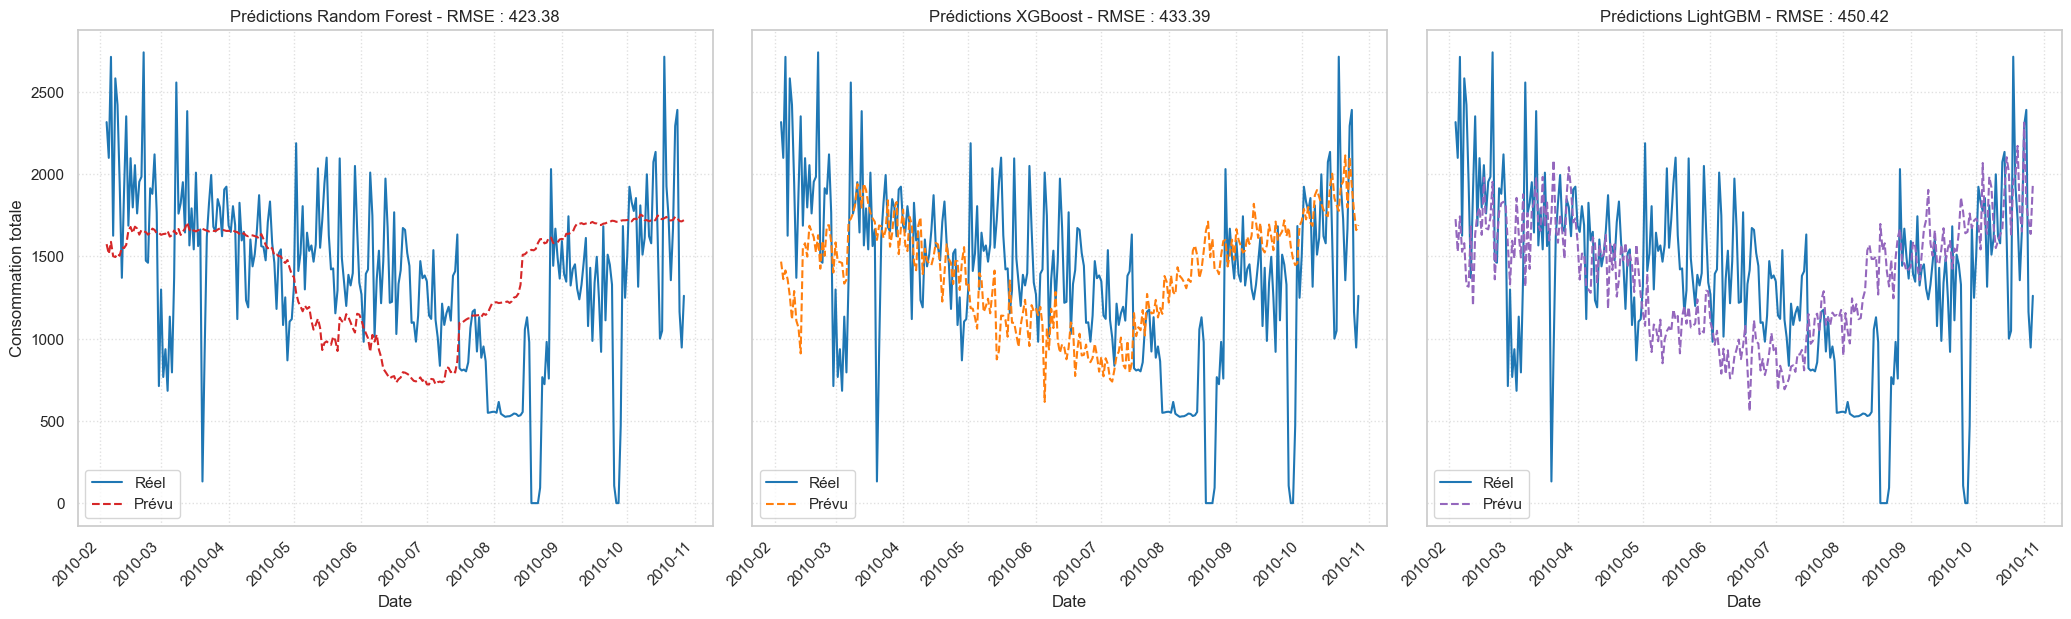

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(21, 6), sharey=True)

couleur_reel = "#1f77b4"        
couleur_rf = "#d62728"          
couleur_xgb = "#ff7f0e"         
couleur_lgbm = "#9467bd"        

axs[0].plot(
    test_df.index,
    test_df["total_consumption"],
    label="Réel",
    color=couleur_reel,
    linestyle="-",
    markersize=5,
)
axs[0].plot(
    test_df.index,
    test_df["Prévision_RandomForest"],
    label="Prévu",
    color=couleur_rf,
    linestyle="--",
    markersize=5,
)
axs[0].set_title(f"Prédictions Random Forest - RMSE : {rmse_rfr:.2f}")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Consommation totale")
axs[0].legend()
axs[0].grid(True, linestyle=":", alpha=0.6)

# --- XGBoost ---
axs[1].plot(
    test_df.index,
    test_df["total_consumption"],
    label="Réel",
    color=couleur_reel,
    linestyle="-",
    markersize=5,
)
axs[1].plot(
    test_df.index,
    test_df["Prévision_XGBoost"],
    label="Prévu",
    color=couleur_xgb,
    linestyle="--",
    markersize=5,
)
axs[1].set_title(f"Prédictions XGBoost - RMSE : {rmse_xgb:.2f}")
axs[1].set_xlabel("Date")
axs[1].legend()
axs[1].grid(True, linestyle=":", alpha=0.6)

# --- LightGBM ---
axs[2].plot(
    test_df.index,
    test_df["total_consumption"],
    label="Réel",
    color=couleur_reel,
    linestyle="-",
    markersize=5,
)
axs[2].plot(
    test_df.index,
    test_df["Prévision_LightGBM"],
    label="Prévu",
    color=couleur_lgbm,
    linestyle="--",
    markersize=5,
)
axs[2].set_title(f"Prédictions LightGBM - RMSE : {rmse_lgbm:.2f}")
axs[2].set_xlabel("Date")
axs[2].legend()
axs[2].grid(True, linestyle=":", alpha=0.6)

plt.tight_layout()
for ax in axs:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")
plt.show()
